In [1]:
%run CycleGAN_main.py --gpu 0 --datapath /root/work/Datasets/Adachi --situations sunny morning --batch_size 1 --result result_sunny2morning --log_dir log_sunny2morning --lambda_id 0.5

Training epoch: 1 [0/1797 (0%)] | D loss (A): 0.555893 | D loss (B): 0.694053 | G loss: 12.751044 | Consistency: 1.113978 |
Training epoch: 1 [100/1797 (6%)] | D loss (A): 0.225385 | D loss (B): 0.323973 | G loss: 4.596547 | Consistency: 0.351290 |
Training epoch: 1 [200/1797 (11%)] | D loss (A): 0.219484 | D loss (B): 0.216813 | G loss: 6.346188 | Consistency: 0.547438 |
Training epoch: 1 [300/1797 (17%)] | D loss (A): 0.181778 | D loss (B): 0.193516 | G loss: 10.701413 | Consistency: 0.985875 |
Training epoch: 1 [400/1797 (22%)] | D loss (A): 0.257462 | D loss (B): 0.199966 | G loss: 5.465158 | Consistency: 0.441692 |
Training epoch: 1 [500/1797 (28%)] | D loss (A): 0.195971 | D loss (B): 0.248919 | G loss: 3.973995 | Consistency: 0.287802 |
Training epoch: 1 [600/1797 (33%)] | D loss (A): 0.238177 | D loss (B): 0.101075 | G loss: 6.125285 | Consistency: 0.462361 |
Training epoch: 1 [700/1797 (39%)] | D loss (A): 0.175529 | D loss (B): 0.138650 | G loss: 6.495945 | Consistency: 0.554

In [1]:
# sunny:2130, cloudy: 146, rainy: 598, night: 876, morning: 1797

In [1]:
%run make_dataset_for_pix2pix.py --directory Data --datapath /root/work/Datasets/Adachi/sunny/

In [ ]:
%run LFSpix2pix_main.py --gpu 1 --batch_size 1 --txtpath ./Data/pair_data.txt --result result_with_lfs --log_dir logs_with_lfs --use_lfs

### A network is Pix2Pix with Latent Filter Scaling.
[64, 192, 448, 960, 1472, 1984, 2496, 3008, 4032, 5056, 6080, 7104, 7616, 7872, 8000]
Training epoch: 1 [0/5751 (0%)] | D loss (A): 0.510624 | G loss: 6.708348 | L1: 0.642892 |
Training epoch: 1 [100/5751 (2%)] | D loss (A): 0.019436 | G loss: 8.075940 | L1: 0.726515 |
Training epoch: 1 [200/5751 (3%)] | D loss (A): 0.014082 | G loss: 8.177788 | L1: 0.734789 |
Training epoch: 1 [300/5751 (5%)] | D loss (A): 0.003247 | G loss: 4.017795 | L1: 0.305406 |
Training epoch: 1 [400/5751 (7%)] | D loss (A): 0.634774 | G loss: 2.623021 | L1: 0.171371 |
Training epoch: 1 [500/5751 (9%)] | D loss (A): 0.001222 | G loss: 5.226205 | L1: 0.424521 |
Training epoch: 1 [600/5751 (10%)] | D loss (A): 0.001185 | G loss: 7.674932 | L1: 0.671633 |
Training epoch: 1 [700/5751 (12%)] | D loss (A): 0.006750 | G loss: 6.541279 | L1: 0.564364 |
Training epoch: 1 [800/5751 (14%)] | D loss (A): 0.000699 | G loss: 7.448956 | L1: 0.647792 |
Training epoch: 1 [900/

In [5]:
path = './Data/pair_data.txt'
with open(path, 'r') as f:
    lines = f.readlines()

if lines[0].split()[0].find('sunny'):
    print('This element includs a word, sunny.')

This element includs a word, sunny.


In [29]:
import os 
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from CycleGAN_models import Generator

model_path_a2b = 'result_sunny2morning/G_a2b'
model_path_b2a = 'result_sunny2morning/G_b2a'
G_a2b = Generator(n_down=2, n_up=2, n_res=9, in_features=3).cuda()
G_a2b.load_state_dict(torch.load(model_path_a2b))
G_a2b.eval()

G_b2a = Generator(n_down=2, n_up=2, n_res=9, in_features=3).cuda()
G_b2a.load_state_dict(torch.load(model_path_b2a))
G_b2a.eval()

resize = transforms.Resize((256, 512))
ToTensor = transforms.ToTensor()
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
normalize = transforms.Normalize(mean=mean, std=std)
mean_ = torch.tensor(mean, dtype=torch.float32)[None,:,None,None]
std_ = torch.tensor(std, dtype=torch.float32)[None,:,None,None]

dataA_dir = '/root/work/Datasets/Adachi/sunny/'
dataB_dir = '/root/work/Datasets/Adachi/morning/'
dataA_list = os.listdir(dataA_dir)
dataB_list = os.listdir(dataB_dir)
min_length = min(len(dataA_list), len(dataB_list))
rand_idx = np.random.randint(min_length)

imgA = Image.open(os.path.join(dataA_dir, dataA_list[rand_idx]))
imgB = Image.open(os.path.join(dataB_dir, dataB_list[rand_idx]))
imgA_tensor = normalize(ToTensor(resize(imgA)))[None,:,:,:].cuda()
imgB_tensor = normalize(ToTensor(resize(imgB)))[None,:,:,:].cuda()

with torch.no_grad():
    fakeB = G_a2b(imgA_tensor)
    fakeA = G_b2a(imgB_tensor)
    fakeB_ = (fakeB.data.cpu() * std_) + mean_
    fakeA_ = (fakeA.data.cpu() * std_) + mean_
    
fakeA_img = Image.fromarray((fakeA_ * 256.).clamp(min=0, max=255).squeeze().permute(1,2,0).numpy().astype(np.uint8))
fakeB_img = Image.fromarray((fakeB_ * 256.).clamp(min=0, max=255).squeeze().permute(1,2,0).numpy().astype(np.uint8))

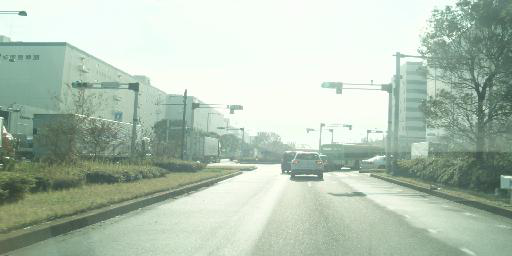

In [30]:
imgA

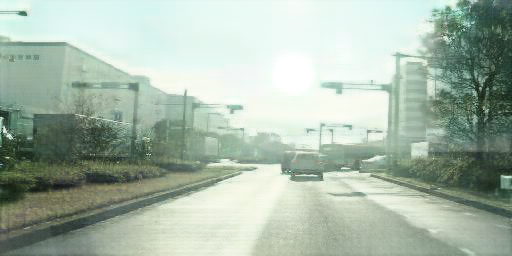

In [31]:
fakeB_img

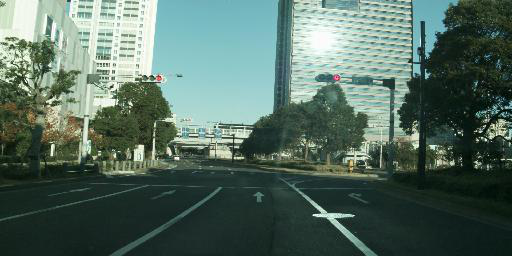

In [32]:
imgB

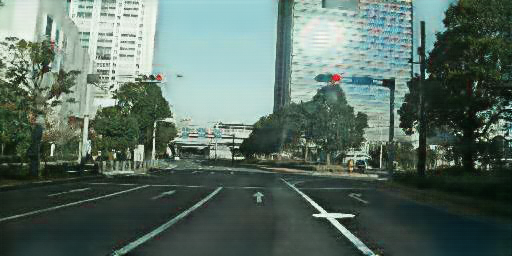

In [33]:
fakeA_img

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from CycleGAN_models import Generator

model_path_a2b = 'result/G_a2b'
model_path_b2a = 'result/G_b2a'
G_a2b = Generator(n_down=2, n_up=2, n_res=9, in_features=3).cuda()
G_a2b.load_state_dict(torch.load(model_path_a2b))
G_a2b.eval()
G_b2a = Generator(n_down=2, n_up=2, n_res=9, in_features=3).cuda()
G_b2a.load_state_dict(torch.load(model_path_b2a))
G_b2a.eval()

resize_img = transforms.Resize((256, 512))
to_tensor = transforms.ToTensor()
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
normalize = transforms.Normalize(mean=mean, std=std)
mean_ = torch.tensor(mean, dtype=torch.float32)[None,:,None,None]
std_ = torch.tensor(std, dtype=torch.float32)[None,:,None,None]
dataA_dir = '/root/work/Datasets/Day2Night/testA'
dataB_dir = '/root/work/Datasets/Day2Night/testB'
data_pix2pix_pair_AB = 'pix2pix_pair_AB_test'
data_pix2pix_pair_BA = 'pix2pix_pair_BA_test'
os.makedirs(data_pix2pix_pair_AB, exist_ok=True)
os.makedirs(data_pix2pix_pair_BA, exist_ok=True)
dataA_list = os.listdir(dataA_dir)
dataB_list = os.listdir(dataB_dir)

for idx, (itemA, itemB) in enumerate(zip(dataA_list, dataB_list)):
    dataA_path = os.path.join(dataA_dir, itemA)
    dataB_path = os.path.join(dataB_dir, itemB) 
    imgA = Image.open(dataA_path)
    imgB = Image.open(dataB_path)
    imgA_tensor = normalize(to_tensor(resize_img(imgA)))[None,:,:,:].cuda()
    imgB_tensor = normalize(to_tensor(resize_img(imgB)))[None,:,:,:].cuda()
    with torch.no_grad():
        fakeB = G_a2b(imgA_tensor)
        fakeA = G_b2a(imgB_tensor)
        fakeB_ = (fakeB.data.cpu() * std_) + mean_
        fakeA_ = (fakeA.data.cpu() * std_) + mean_
        #print(fakeA.shape)
    imgA_f = Image.fromarray((fakeA_ * 256.).clamp(min=0, max=255).squeeze().numpy().transpose(1,2,0).astype(np.uint8))
    imgB_f = Image.fromarray((fakeB_ * 256.).clamp(min=0, max=255).squeeze().data.cpu().numpy().transpose(1,2,0).astype(np.uint8))
    imgA.resize((512, 256)).save(os.path.join(data_pix2pix_pair_AB, 'img{:0>6}_real.jpg'.format(idx)))
    imgB_f.save(os.path.join(data_pix2pix_pair_AB, 'img{:0>6}_fake.jpg'.format(idx)))
    
    imgB.resize((512, 256)).save(os.path.join(data_pix2pix_pair_BA, 'img{:0>6}_real.jpg'.format(idx)))
    imgA_f.save(os.path.join(data_pix2pix_pair_BA, 'img{:0>6}_fake.jpg'.format(idx)))

In [4]:
import os
import shutil
from PIL import Image
main_dir = 'Data'
txtpath_s2n = os.path.join(main_dir, 'sunny2night.txt')
txtpath_s2m = os.path.join(main_dir, 'sunny2morning.txt')
items = os.listdir(main_dir)
sunny_path = './Data/sunny'
morning_path = './Data/morning'
night_path = './Data/night/'
sunny_imgs = sorted(os.listdir(sunny_path))
morning_imgs = sorted(os.listdir(morning_path))
night_imgs = sorted(os.listdir(night_path))


for (sunny_img, night_img, morning_img) in zip(sunny_imgs, night_imgs, morning_imgs):
    sunny_img_path = os.path.join(sunny_path, sunny_img)
    night_img_path = os.path.join(night_path, night_img)
    morning_img_path = os.path.join(morning_path, morning_img)
    
    with open(txtpath_s2n, 'a') as f:
        f.write(sunny_img_path + ' ' + night_img_path + '\n')
    with open(txtpath_s2m, 'a') as f:
        f.write(sunny_img_path + ' ' + morning_img_path + '\n')

2130 2130 2130


In [33]:
import random
with open(txtpath, 'r') as f:
    lines = f.readlines()
    
random.shuffle(lines)
torch.tensor(int(lines[0].split()[2]))

tensor(0)

In [10]:
import shutil
os.removedirs(os.path.join(dataA_dir, sorted(dataA_list)[0]))

FileNotFoundError: [Errno 2] No such file or directory: '/root/work/Datasets/Day2Night/trainA/.ipynb_checkpoints'

In [7]:
import os
import shutil
path = '/root/work/Datasets/Adachi/sunny/.'
shutil.rmtree(path)
#os.removedirs(path)